# Packages

In [1]:
import torch,os,tqdm,importlib,warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from zipfile import ZipFile
import tool.sodt_utils as sodt_utils
import tool.evaluator as lhtevaluator
warnings.filterwarnings("ignore")

In [2]:
importlib.reload(sodt_utils)
importlib.reload(lhtevaluator)

<module 'tool.evaluator' from '/home/hxl170008/code/git_repos/SODT_ResNet/tool/evaluator.py'>

# unzip dataset 'NDT_Deer.zip'
- please download ['NDT_Deer.zip'](https://utdallas.app.box.com/file/1301463614054?s=biyodywd89tteyposrmte994k3x6tnu7&sb=/activity) to the folder 'data'
- unzip the zip file.

In [3]:
p = r"data/NDT_Deer.zip"
with ZipFile(p,'r') as zObject:
    zObject.extractall(path=r"data")

# Dataset Architecture
- |-NDT_Deer
    - |-Annotations # store all annotation files (.txt). annotation format: [label,xmin,ymin,xmax,ymax]
    - |-JPGImages # store all jpg files
    - |-Test
        - |-anns.txt
        - |-imgs.txt
    - |-Train
        - |-anns.txt
        - |-imgs.txt

# Dataset Configure

- small object: $area \le 187$
- medium object: $187< area \le 408$
- large: $area > 408$

In [3]:
class Config:
    root = r'data/NDT_Deer' # 
    img_path = r'data/NDT_Deer/JPGImages/0'
    ann_path = r'data/NDT_Deer/Annotations'
    pretrained = "pretrained"
    areaRng = [[0, 10000000000.0], [0,187],[187.5,405],[408,10000000000.0]]
#
opt = Config()

#  Distribution of BBox Areas and Num objects per image

In [4]:
fp1 = os.path.join(opt.root, 'Train','imgs.txt')
fp2 = os.path.join(opt.root, 'Train','anns.txt')
trainImgs = np.loadtxt(fp1,dtype=str)
trainAnns = np.loadtxt(fp2,dtype=str)
#
fp1 = os.path.join(opt.root, 'Test','imgs.txt')
fp2 = os.path.join(opt.root, 'Test','anns.txt')
testImgs = np.loadtxt(fp1,dtype=str)
testAnns = np.loadtxt(fp2,dtype=str)
#
images = trainImgs.tolist() + testImgs.tolist()
annotations = trainAnns.tolist() + testAnns.tolist()
imgDS = sodt_utils.BBoxDataset(root=opt.root,imgs=images,anns=annotations,transform=sodt_utils.get_transform())
areas = []
numPerImg = []
if hasattr(tqdm,'notebook'):
    pr = tqdm.notebook.trange(len(imgDS))
else:
    pr = tqdm.tqdm_notebook(range(len(imgDS)))
for i in pr:
    _,tgt = imgDS[i]
    a = tgt['area']
    b = tgt['boxes'].numpy()
    numPerImg.append(len(a))
    for bbid,j in enumerate(range(len(a))):
        areas.append(a[j].item())
    #
    

  0%|          | 0/2277 [00:00<?, ?it/s]

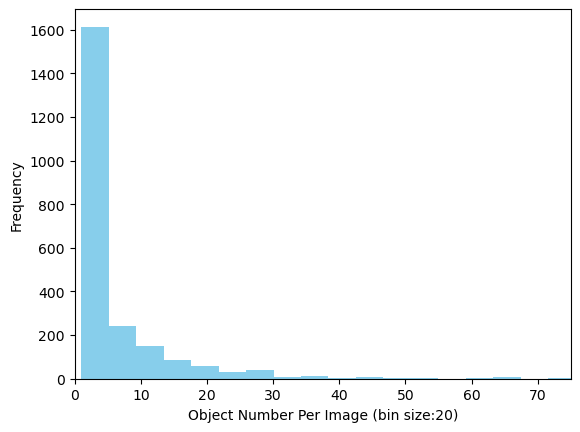

In [8]:
fig, ax = plt.subplots(1,1)
ax.hist(numPerImg,bins=20, color='skyblue')
ax.set_xlabel('Object Number Per Image (bin size:20)')
ax.set_ylabel('Frequency')
ax.set_xlim([0,75])
plt.show()

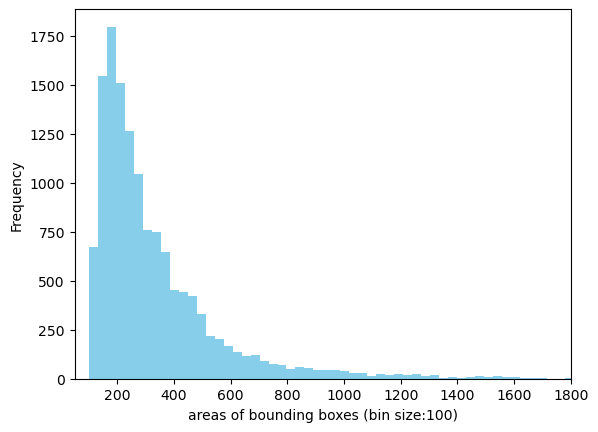

In [6]:
fig, ax = plt.subplots(1,1)
ax.hist(areas, bins=100, color='skyblue')
ax.set_xlabel('areas of bounding boxes (bin size:100)')
ax.set_ylabel('Frequency')
ax.set_xlim([50,1800])
plt.show()

# Criterion for Small, Medium, and Big Object  
- Small object: area <=200  
- Medium object: 200 < area <=400  
- Big object : area > 400

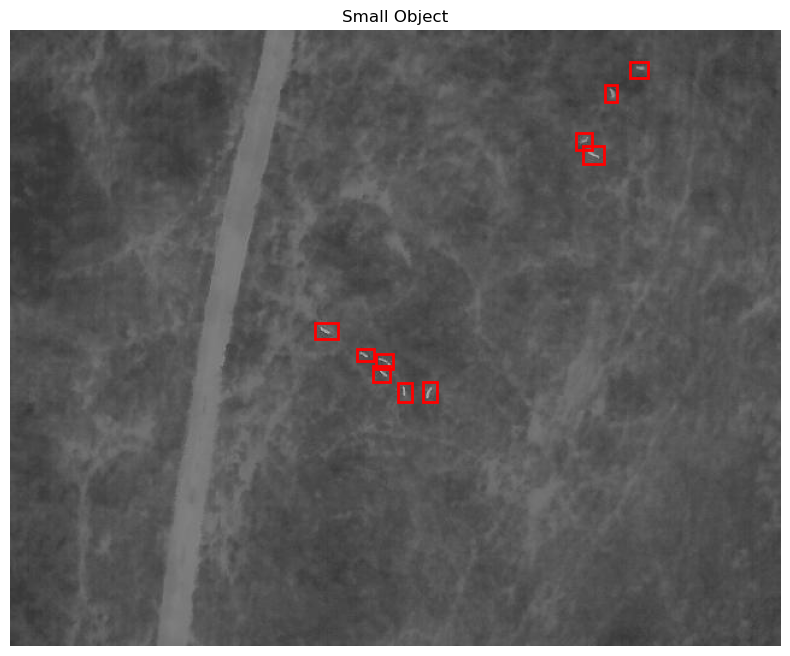

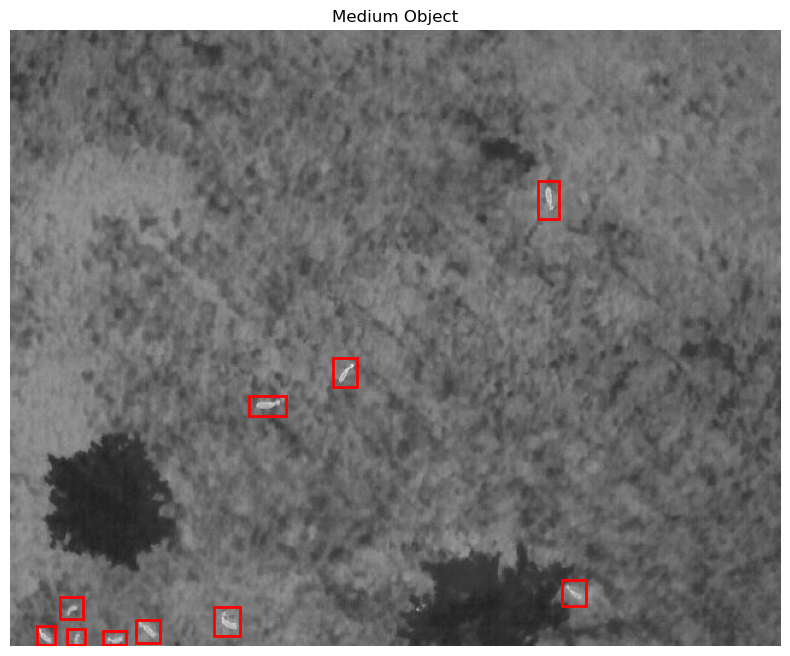

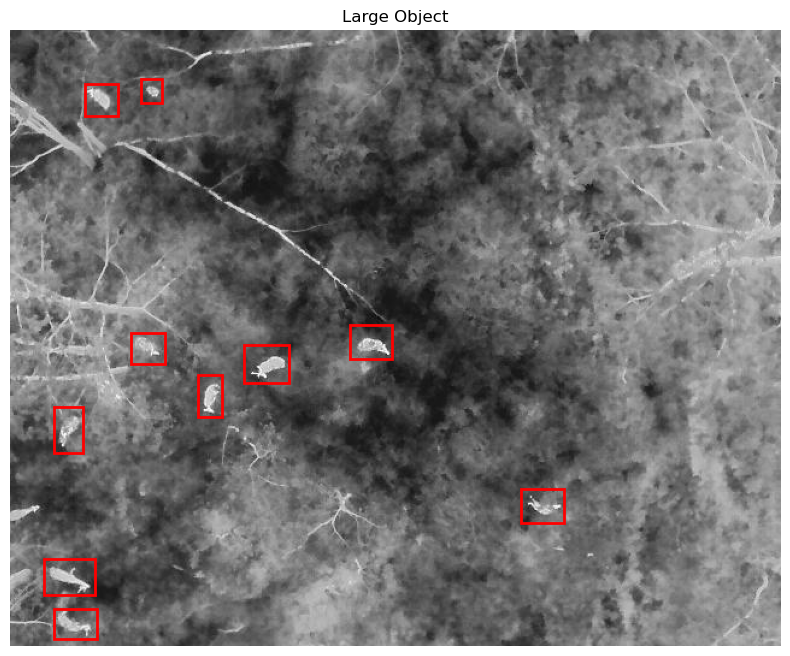

In [14]:
imgDS = sodt_utils.BBoxDataset(root=opt.root,transform=None)
sid, mid, bid = 1388,1016,1597
img_s, box_s = imgDS[sid]
img_s = np.asarray(img_s)
box_s = box_s['boxes'].numpy()
#
img_m, box_m = imgDS[mid]
img_m = np.asarray(img_m)
box_m = box_m['boxes'].numpy()
#
img_b, box_b = imgDS[bid]
img_b = np.asarray(img_b)
box_b = box_b['boxes'].numpy()
#
ax = sodt_utils.lht_vis_bbox(img_s,box_s,figsize=(10,8))
ax.set_title('Small Object')
ax.set_axis_off()
#
ax = sodt_utils.lht_vis_bbox(img_m,box_m,figsize=(10,8))
ax.set_title('Medium Object')
ax.set_axis_off()
#
ax = sodt_utils.lht_vis_bbox(img_b,box_b,figsize=(10,8))
ax.set_title('Large Object')
ax.set_axis_off()

# Dataset Construction for training and testing

In [5]:
fp1 = os.path.join(opt.root, 'Train','imgs.txt')
fp2 = os.path.join(opt.root, 'Train','anns.txt')
trainImgs = np.loadtxt(fp1,dtype=str)
trainAnns = np.loadtxt(fp2,dtype=str)
#
fp1 = os.path.join(opt.root, 'Test','imgs.txt')
fp2 = os.path.join(opt.root, 'Test','anns.txt')
testImgs = np.loadtxt(fp1,dtype=str)
testAnns = np.loadtxt(fp2,dtype=str)
#
trainDS = sodt_utils.BBoxDataset(root=opt.root,imgs=trainImgs,anns=trainAnns,transform=sodt_utils.get_transform())
testDS  = sodt_utils.BBoxDataset(root=opt.root,imgs=testImgs,anns=testAnns, transform=sodt_utils.get_transform())
#
train_loader = torch.utils.data.DataLoader(trainDS,batch_size=5,shuffle=True, num_workers=4, collate_fn=sodt_utils.collate_fn)
test_loader  = torch.utils.data.DataLoader(testDS,batch_size=5,shuffle=False, num_workers=2, collate_fn=sodt_utils.collate_fn)
f'train:{len(trainDS)}, test: {len(testDS)}'

'train:1833, test: 444'

# Model Construction

- M1: FRC_ResNet18FPN: FPN based on ResNet18
- M2: FRC_ResNet34FPN: FPN based on ResNet34
- M3: FRC_ResNet50FPN: FPN based on ResNet50
- M4: FRC_ResNet101FPN: FPN based on ResNet101  
- M5: FRC_ResNet152FPN: FPN based on ResNet152

In [6]:
M1 = sodt_utils.constructFRC_ResNet(resnet_name='resnet18')
M2 = sodt_utils.constructFRC_ResNet(resnet_name='resnet34')
M3 = sodt_utils.constructFRC_ResNet(resnet_name='resnet50')
M4 = sodt_utils.constructFRC_ResNet(resnet_name='resnet101')
M5 = sodt_utils.constructFRC_ResNet(resnet_name='resnet152')

# Example of training a model

In [40]:
M1 = sodt_utils.constructModel(name='M1')
device = torch.device("cuda")
M1.to(device)
epoch=1
params = [p for p in M1.parameters() if p.requires_grad]
#optimizer = torch.optim.SGD(params, lr=0.0001)
optimizer = torch.optim.Adam(params, lr=0.0001)
logger=sodt_utils.lht_train_one_epoch(M1,optimizer,train_loader,device,epoch,print_freq=len(train_loader),warm=False)

  0%|▏                                                                              | 1/367 [00:00<03:17,  1.86it/s]

Epoch: [1] [  0/367] eta: 0:03:18 lr: 0.000100 loss: 17169932.0000 (17169932.0000) time: 0.5412 data: 0.2627 max mem: 15128


Epoch: [1] [366/367] eta: 0:00:00 lr: 0.000100 loss: 1.3826 (74567.7201) time: 0.3445 data: 0.0121 max mem: 16754
Epoch: [1] Total time: 0:02:13 (0.3634 s / it)


In [54]:
p = r"pretrained/cfg_resnet.zip"
with ZipFile(p,'r') as zObject:
    zObject.extractall(path=r"pretrained")

In [7]:
M1.load_state_dict(torch.load(r'pretrained/cfg_resnet/M1_fpn_resnet18.ckpt'))
M1 = M1.cpu()
M2.load_state_dict(torch.load(r'pretrained/cfg_resnet/M2_fpn_resnet34.ckpt'))
M2 = M2.cpu()
M3.load_state_dict(torch.load(r'pretrained/cfg_resnet/M3_fpn_resnet50.ckpt'))
M3 = M3.cpu()
M4.load_state_dict(torch.load(r'pretrained/cfg_resnet/M4_fpn_resnet101.ckpt'))
M4 = M4.cpu()
M5.load_state_dict(torch.load(r'pretrained/cfg_resnet/M5_fpn_resnet152.ckpt'))
M5 = M5.cpu()

# Generate COCO Evaluation Matrix

In [9]:
device = torch.device("cuda")
ret_m1 = sodt_utils.getAPSmallMediumBig(model=M1,testAnns=testAnns, testImgs=testImgs, root=opt.root, areaRng=opt.areaRng)
ret_m2 = sodt_utils.getAPSmallMediumBig(model=M2,testAnns=testAnns, testImgs=testImgs, root=opt.root, areaRng=opt.areaRng)
ret_m3 = sodt_utils.getAPSmallMediumBig(model=M3,testAnns=testAnns, testImgs=testImgs, root=opt.root, areaRng=opt.areaRng)
ret_m4 = sodt_utils.getAPSmallMediumBig(model=M4,testAnns=testAnns, testImgs=testImgs, root=opt.root, areaRng=opt.areaRng)
ret_m5 = sodt_utils.getAPSmallMediumBig(model=M5,testAnns=testAnns, testImgs=testImgs, root=opt.root, areaRng=opt.areaRng)

  0%|          | 0/444 [00:00<?, ?it/s]

creating index...
index created!


  0%|          | 0/22 [00:00<?, ?it/s]

Accumulating evaluation results...
DONE (t=0.02s).
creating index...
index created!


  0%|          | 0/42 [00:00<?, ?it/s]

Accumulating evaluation results...
DONE (t=0.04s).
creating index...
index created!


  0%|          | 0/26 [00:00<?, ?it/s]

Accumulating evaluation results...
DONE (t=0.02s).
creating index...
index created!


  0%|          | 0/89 [00:00<?, ?it/s]

Accumulating evaluation results...
DONE (t=0.07s).


  0%|          | 0/444 [00:00<?, ?it/s]

creating index...
index created!


  0%|          | 0/22 [00:00<?, ?it/s]

Accumulating evaluation results...
DONE (t=0.03s).
creating index...
index created!


  0%|          | 0/42 [00:00<?, ?it/s]

Accumulating evaluation results...
DONE (t=0.04s).
creating index...
index created!


  0%|          | 0/26 [00:00<?, ?it/s]

Accumulating evaluation results...
DONE (t=0.02s).
creating index...
index created!


  0%|          | 0/89 [00:00<?, ?it/s]

Accumulating evaluation results...
DONE (t=0.09s).


  0%|          | 0/444 [00:00<?, ?it/s]

creating index...
index created!


  0%|          | 0/22 [00:00<?, ?it/s]

Accumulating evaluation results...
DONE (t=0.02s).
creating index...
index created!


  0%|          | 0/42 [00:00<?, ?it/s]

Accumulating evaluation results...
DONE (t=0.03s).
creating index...
index created!


  0%|          | 0/26 [00:00<?, ?it/s]

Accumulating evaluation results...
DONE (t=0.02s).
creating index...
index created!


  0%|          | 0/89 [00:00<?, ?it/s]

Accumulating evaluation results...
DONE (t=0.06s).


  0%|          | 0/444 [00:00<?, ?it/s]

creating index...
index created!


  0%|          | 0/22 [00:00<?, ?it/s]

Accumulating evaluation results...
DONE (t=0.02s).
creating index...
index created!


  0%|          | 0/42 [00:00<?, ?it/s]

Accumulating evaluation results...
DONE (t=0.03s).
creating index...
index created!


  0%|          | 0/26 [00:00<?, ?it/s]

Accumulating evaluation results...
DONE (t=0.02s).
creating index...
index created!


  0%|          | 0/89 [00:00<?, ?it/s]

Accumulating evaluation results...
DONE (t=0.06s).


  0%|          | 0/444 [00:00<?, ?it/s]

creating index...
index created!


  0%|          | 0/22 [00:00<?, ?it/s]

Accumulating evaluation results...
DONE (t=0.02s).
creating index...
index created!


  0%|          | 0/42 [00:00<?, ?it/s]

Accumulating evaluation results...
DONE (t=0.03s).
creating index...
index created!


  0%|          | 0/26 [00:00<?, ?it/s]

Accumulating evaluation results...
DONE (t=0.02s).
creating index...
index created!


  0%|          | 0/89 [00:00<?, ?it/s]

Accumulating evaluation results...
DONE (t=0.06s).


In [10]:
df = pd.DataFrame()
df['COCO_index'] = list(ret_m1.keys())
df['M1'] = list(ret_m1.values())
df['M2'] = list(ret_m2.values())
df['M3'] = list(ret_m3.values())
df['M4'] = list(ret_m4.values())
df['M5'] = list(ret_m5.values())
df.set_index('COCO_index', inplace=True)
df

M1        M2        M3        M4        M5
COCO_index                                                          
AP_0.5_all          0.879145  0.881133  0.851786  0.839723  0.859140
AP_0.5_small        0.691423  0.689310  0.666039  0.626058  0.660294
AP_0.5_medium       0.919323  0.924114  0.904190  0.896368  0.907235
AP_0.5_large        0.926911  0.923132  0.906265  0.910924  0.907501
AP_0.5:0.95_small   0.297150  0.299028  0.279091  0.259249  0.276124
AP_0.5:0.95_medium  0.390760  0.385279  0.407012  0.398781  0.405576
AP_0.5:0.95_large   0.466260  0.470218  0.474070  0.471831  0.477211
AR_0.5:0.95_small   0.449738  0.484817  0.407155  0.400873  0.411344
AR_0.5:0.95_medium  0.508992  0.523123  0.524506  0.525988  0.527075
AR_0.5:0.95_large   0.548529  0.541830  0.547386  0.544444  0.547876

# Test

In [21]:
MS = {
    'FRC_ResNet18FPN':M1,
    'FRC_ResNet34FPN':M2,
    'FRC_ResNet50FPN':M3,
    'FRC_ResNet101FPN':M4,
    'FRC_ResNet152FPN':M5,
}

## a test image containing 7 animals

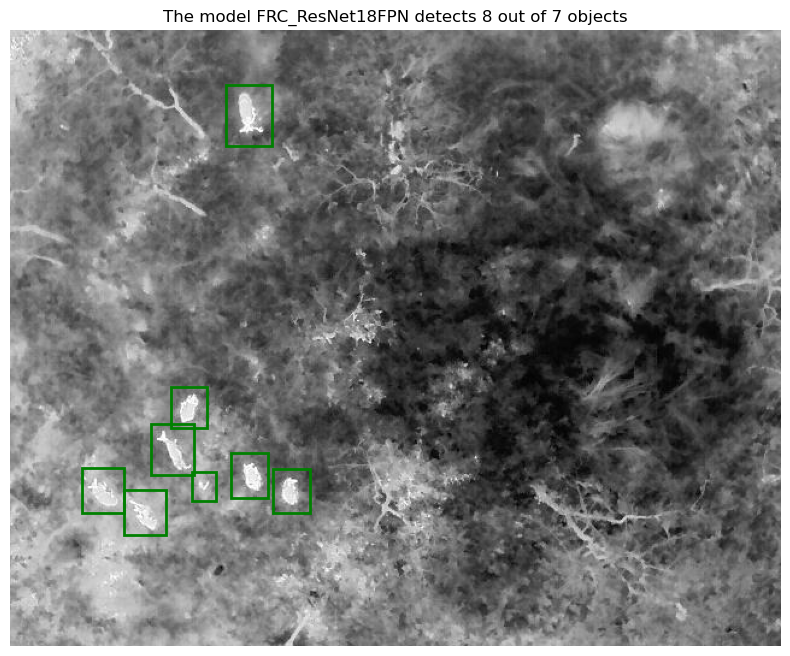

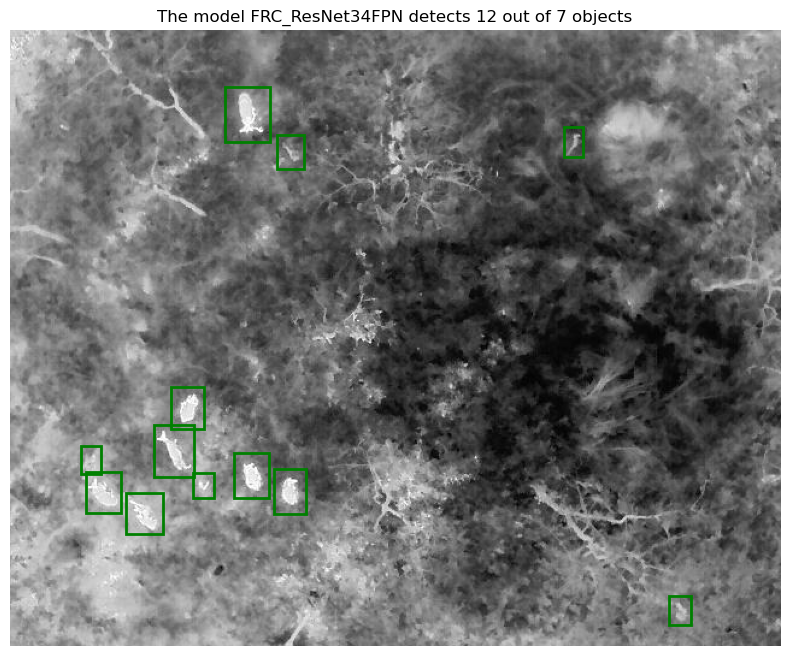

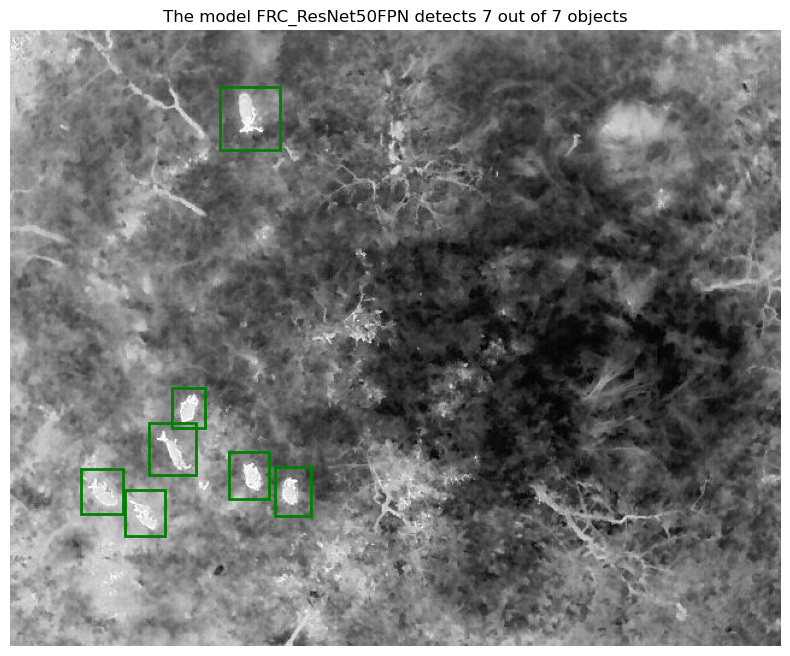

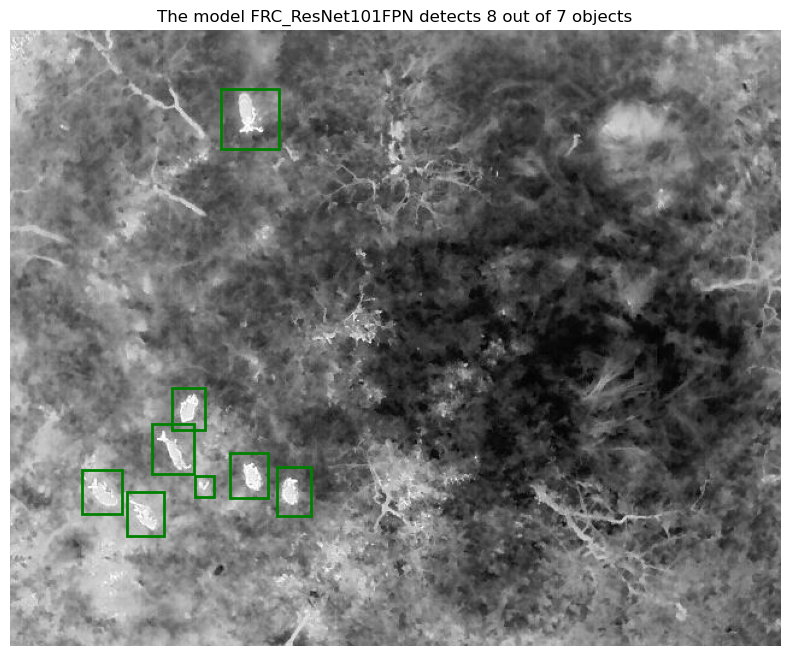

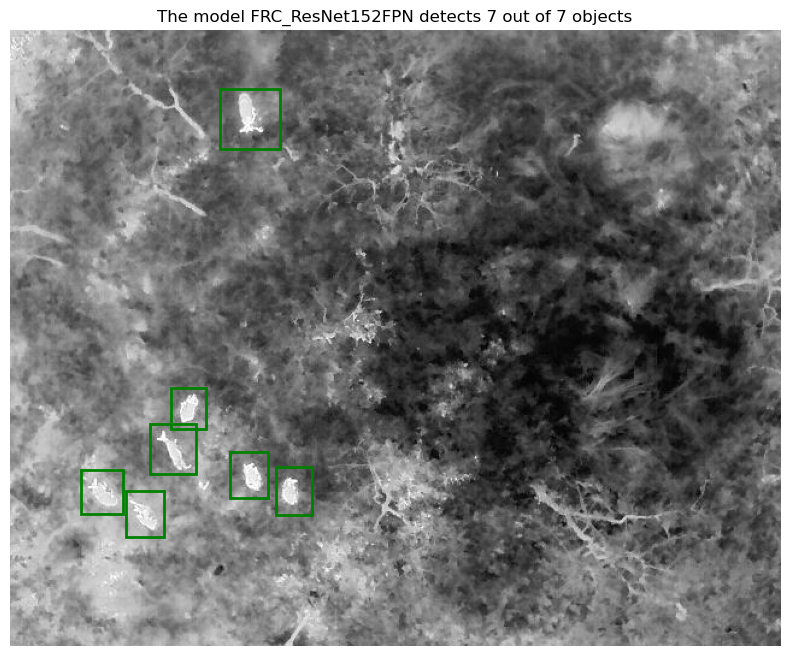

In [22]:
p = r'testImages/4_355_7.JPG'
for k,M in MS.items():
    M.roi_heads.nms_thresh = 0.2
    img, pred = sodt_utils.smallObjDetection(M,p)
    boxes = pred['boxes']
    boxes = boxes.detach().cpu().numpy()
    img = img.numpy()
    ax = sodt_utils.lht_vis_bbox(img*255,boxes,edgecolor='green',figsize=(10,8))
    ax.set_title(f'The model {k} detects {boxes.shape[0]} out of 7 objects')
    ax.set_axis_off()

## a test image containing 17 animals

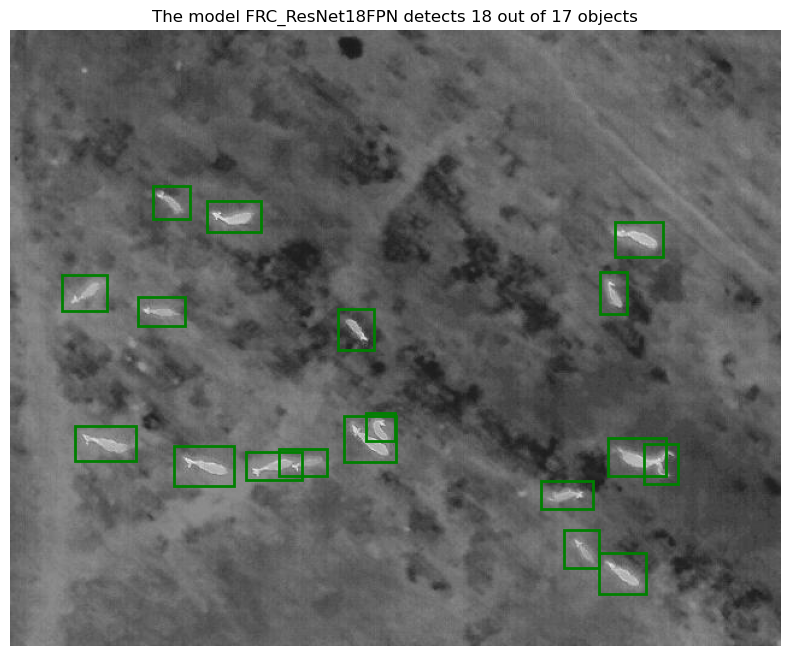

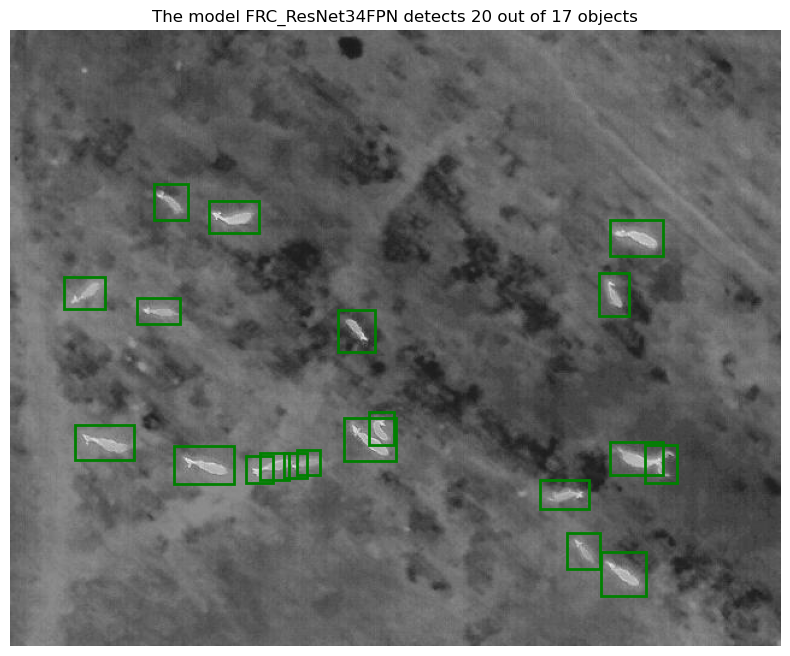

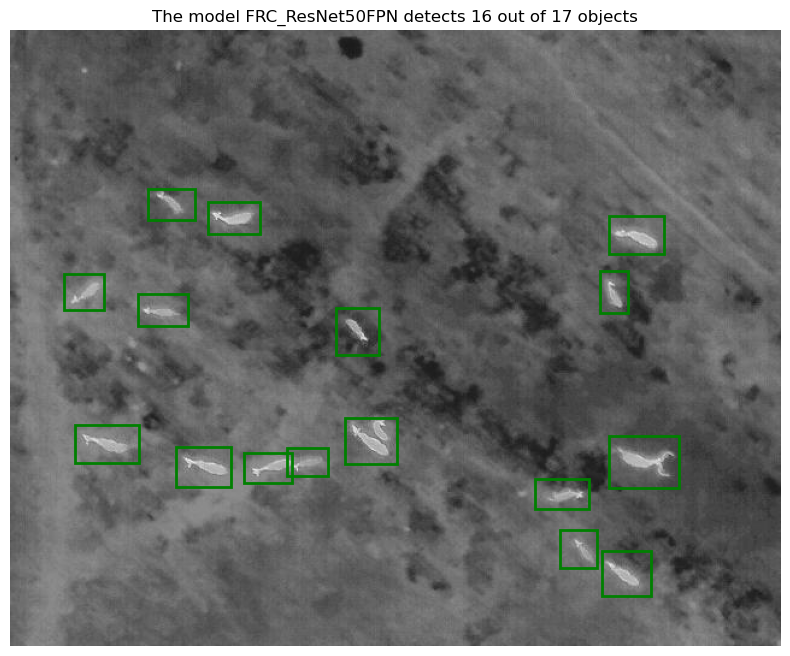

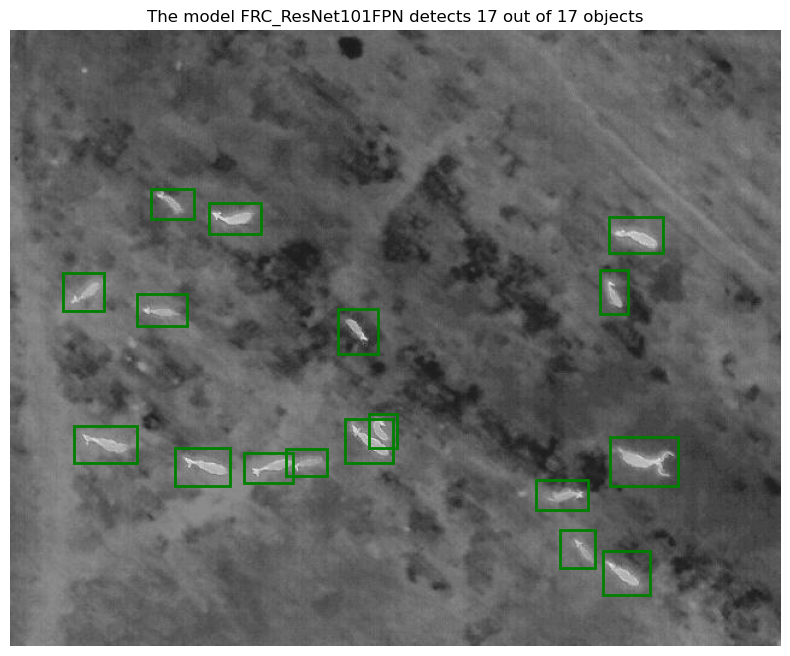

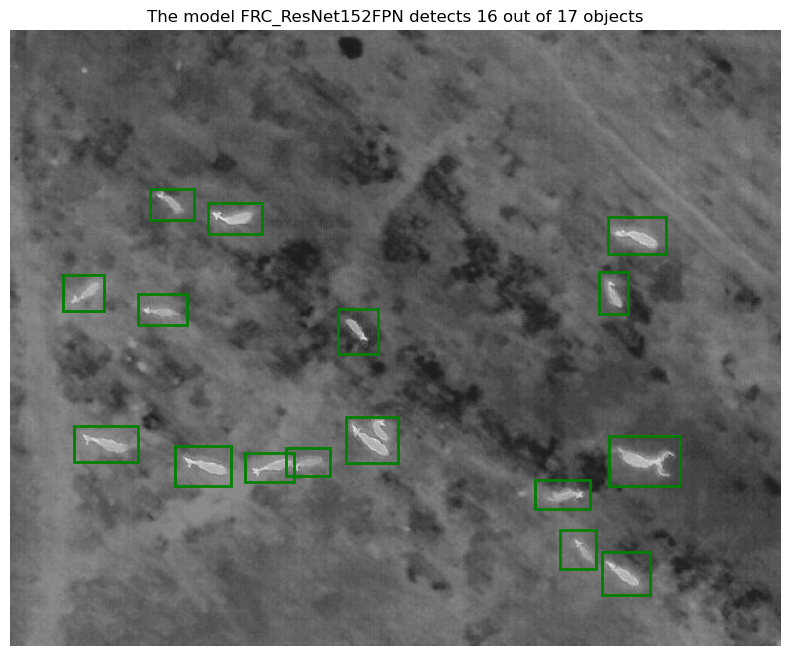

In [28]:
p = r'testImages/4_1670_17.JPG'
for k,M in MS.items():
    M.roi_heads.nms_thresh = 0.3
    img, pred = sodt_utils.smallObjDetection(M,p)
    boxes = pred['boxes']
    boxes = boxes.detach().cpu().numpy()
    img = img.numpy()
    ax = sodt_utils.lht_vis_bbox(img*255,boxes,edgecolor='green',figsize=(10,8))
    ax.set_title(f'The model {k} detects {boxes.shape[0]} out of 17 objects')
    ax.set_axis_off()

## a test image containing 30 animals

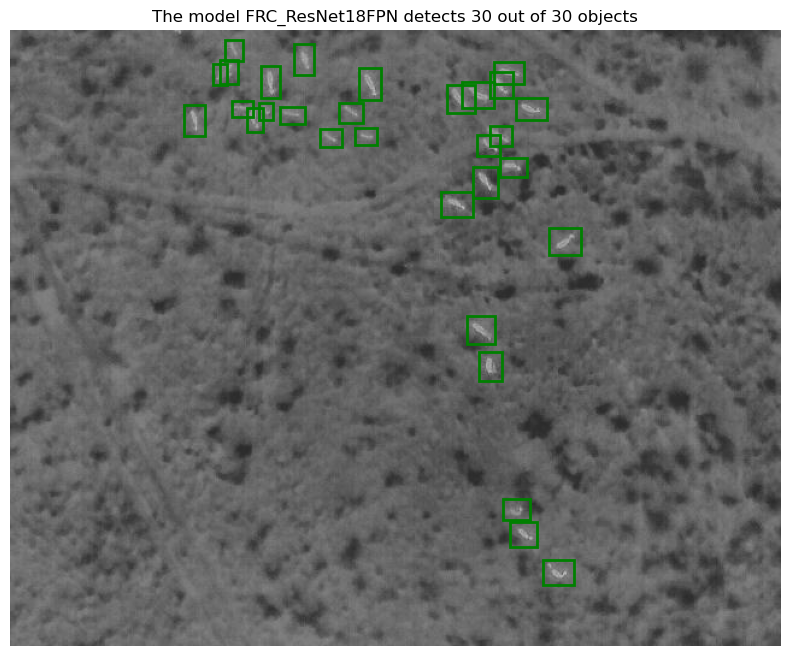

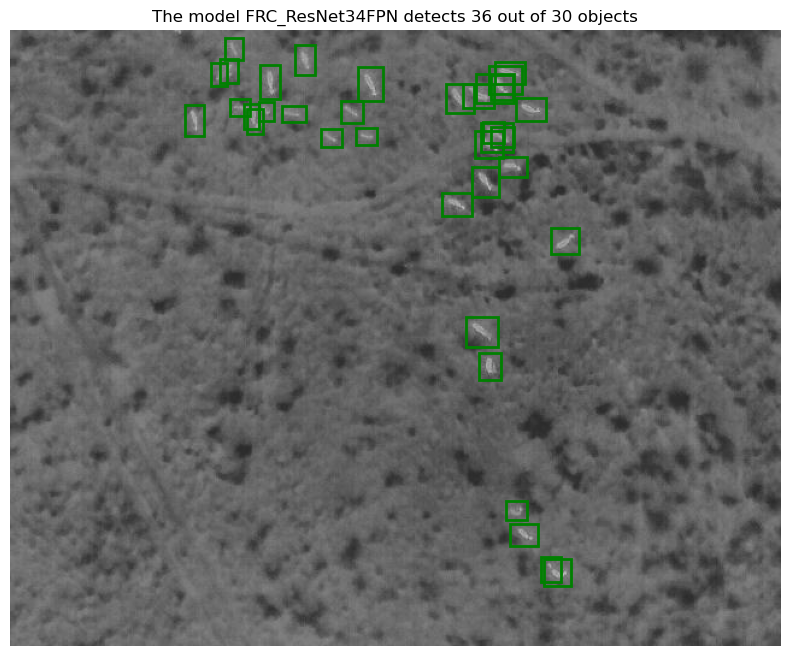

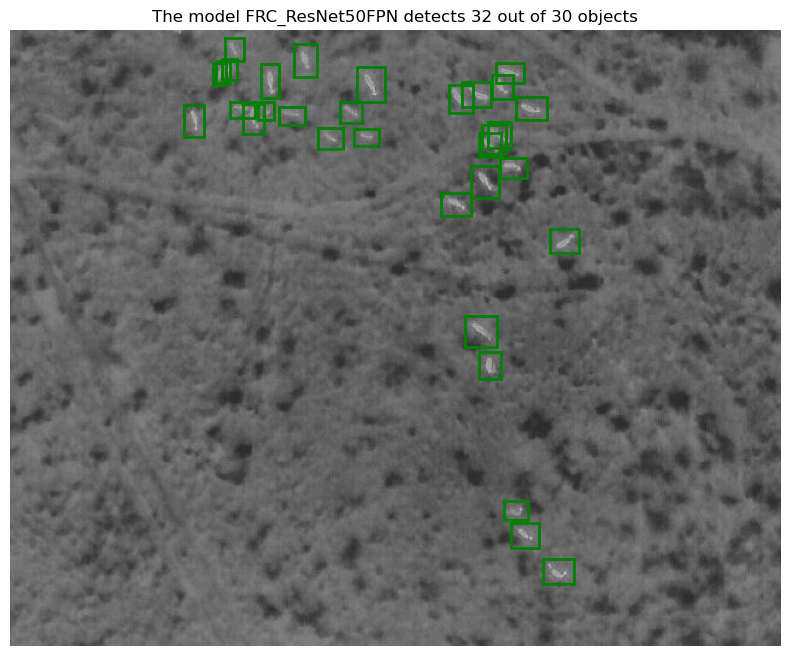

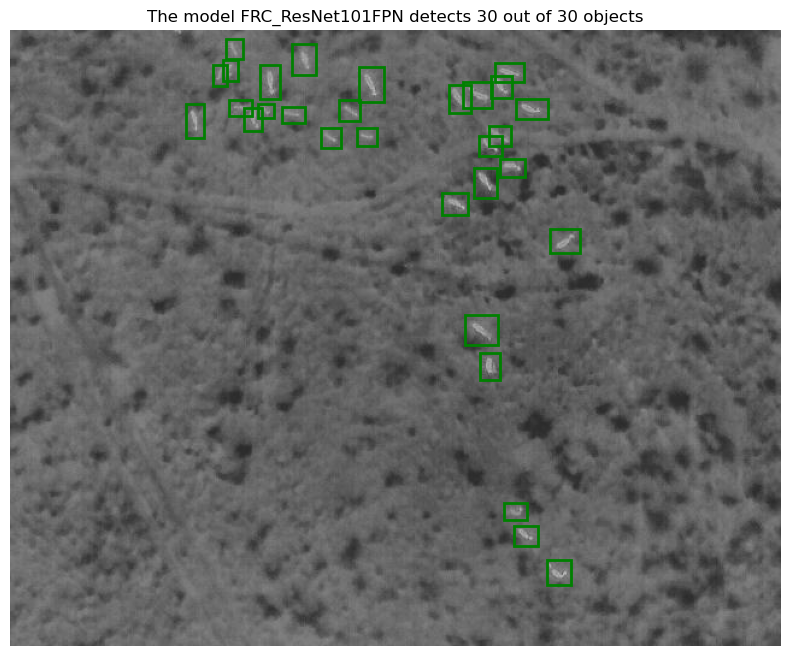

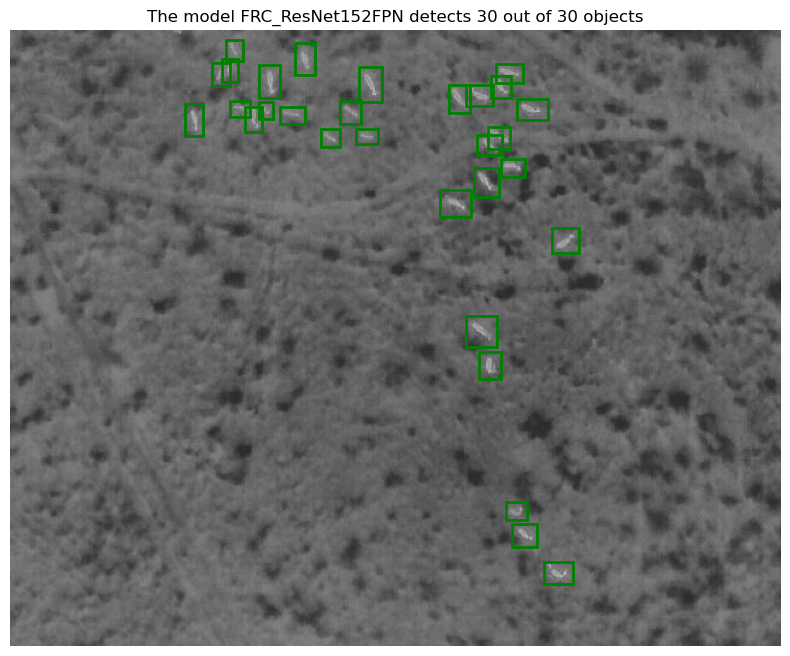

In [26]:
p = r'testImages/4_1636_30.JPG'
for k,M in MS.items():
    M.roi_heads.nms_thresh = 0.5
    img, pred = sodt_utils.smallObjDetection(M,p)
    boxes = pred['boxes']
    boxes = boxes.detach().cpu().numpy()
    img = img.numpy()
    ax = sodt_utils.lht_vis_bbox(img*255,boxes,edgecolor='green',figsize=(10,8))
    ax.set_title(f'The model {k} detects {boxes.shape[0]} out of 30 objects')
    ax.set_axis_off()

# SODT_ResNet  
[![License: CC BY-NC-SA 4.0](https://img.shields.io/badge/License-CC_BY--NC--SA_4.0-lightgrey.svg)](https://creativecommons.org/licenses/by-nc-sa/4.0/)  
ResNet18, ResNet34, ResNet50, ResNet101, and ResNet152 are respectively used as bacbone to construct object detection model based on Faster RCNN  

Code for paper "[Deer survey from drone thermal imagery using enhanced faster R-CNN based on ResNets and FPN](https://doi.org/10.1016/j.ecoinf.2023.102383)"  

> This paper is supported by a NSF project "Feedbacks Between Human Community Dynamics and Sociobiological Vulnerability in a Biodiversity Hotspot" (BCS-1211498)  
Due to the restrictions of the confidentiality agreement, we are unable to fully disclose all thermal image datasets. However, within the limits allowed by the agreement, we are sharing a portion of the thermal images to construct a training dataset for validating the models proposed in this paper. Consequently, the performance of models trained with these datasets may be lower compared to the models discussed in this paper.  

## Citation
If you use this code in your work, please cite our [paper](https://doi.org/10.1016/j.ecoinf.2023.102383):  
```
@article{
    title = {Deer survey from drone thermal imagery using enhanced faster R-CNN based on ResNets and FPN},
    journal = {Ecological Informatics},
    volume = {79},
    year = {2024},
    issn = {1574-9541},
    doi = {https://doi.org/10.1016/j.ecoinf.2023.102383},
    url = {https://www.sciencedirect.com/science/article/pii/S1574954123004120},
    author = {Haitao Lyu, Fang Qiu, Li An, Douglas Stow, Rebecca Lewison, Eve Bohnett}
    }
```

## Model Architecture  
![](https://ars.els-cdn.com/content/image/1-s2.0-S1574954123004120-gr3_lrg.jpg)  

## Detection Examples  
![](https://ars.els-cdn.com/content/image/1-s2.0-S1574954123004120-gr14_lrg.jpg)  

![](https://ars.els-cdn.com/content/image/1-s2.0-S1574954123004120-gr15_lrg.jpg) 
> Fig. 14,15. (a) denotes the original image with the ground-true bounding boxes marked in red. (b) denotes the output of FRC_ResNet18FPN. (C) denotes the output of FRC_ResNet34FPN. (d) denotes the output of FRC_ResNet50FPN. (e) denotes the output of FRC_ResNet101FPN. (f) denotes the output of FRC_ResNet152FPN.

![](https://ars.els-cdn.com/content/image/1-s2.0-S1574954123004120-gr17_lrg.jpg)
> Fig. 17. (a) The detection results from the model using big-scale anchor boxes. (b) The detection results from the model using small-scale anchor boxes. The three red arrows point at the objects missed by the model in (a).  

## License
HerdNet follows [`CC BY-NC-SA-4.0`](https://github.com/Alexandre-Delplanque/HerdNet/blob/main/LICENSE.md) license and is thus open source and freely available for academic research purposes only, no commercial use is permitted.  
